<a href="https://colab.research.google.com/github/tortoisehare/TSR-GAN/blob/master/GAN_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
#torch.multiprocessing.set_start_method("spawn") 

import torch.optim
print(torch.__version__)
#from torch import np

import matplotlib
matplotlib.use('Agg')       
get_ipython().magic('matplotlib inline')
from matplotlib import pyplot    
from matplotlib.pyplot import subplot     
from sklearn.metrics import accuracy_score


# Target Model definition - LeNet 5
class target_net(nn.Module):
    def __init__(self):
        super(target_net, self).__init__()

        # LAYER 1: Convolution, Input 1x32x32, Output 6x28x28
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0, bias=True)
        # Max-pooling, Input 6x28x28, Output 6x14x14
        self.max_pool_1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        # Dropout
        self.drop1 = torch.nn.Dropout(0.5)
       
        # LAYER 2: Convolution, Input 6x14x14, Output 16x10x10
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=True)
        # Max-pooling, Input 16x10x10, Output 16x5x5
        self.max_pool_2 = torch.nn.MaxPool2d(kernel_size=2, stride=2) 
        # Dropout
        self.drop2 = torch.nn.Dropout(0.5)
        
        # LAYER 3: FC, Input 400, Output 120
        self.fc1 = torch.nn.Linear(16*5*5, 120)   # convert matrix with 16*5*5 (= 400) features to a matrix of 120 features (columns)
        self.drop3 = torch.nn.Dropout(0.5)
        
        # LAYER 4: FC, Input 120, Output 84
        self.fc2 = torch.nn.Linear(120, 84)       # convert matrix with 120 features to a matrix of 84 features (columns)
        self.drop4 = torch.nn.Dropout(0.5)
        
        # LAYER 5: FC Input 84, Output 43
        self.fc3 = torch.nn.Linear(84, 43)        # convert matrix with 84 features to a matrix of 43 features (columns)
        


    def forward(self, x):
        # convolve, then perform ReLU non-linearity
        x = torch.nn.functional.relu(self.conv1(x))  
        # max-pooling with 2x2 grid 
        x = self.max_pool_1(x) 
        # convolve, then perform ReLU non-linearity
        x = torch.nn.functional.relu(self.conv2(x))
        # max-pooling with 2x2 grid
        x = self.max_pool_2(x)
        # first flatten 'max_pool_2_out' to contain 16*5*5 columns
        # read through https://stackoverflow.com/a/42482819/7551231
        
        x = x.view(-1, 16*5*5)
        # FC-1, then perform ReLU non-linearity
        x = torch.nn.functional.relu(self.fc1(x))
        # FC-2, then perform ReLU non-linearity
        x = torch.nn.functional.relu(self.fc2(x))
        # FC-3
        x = self.fc3(x)
        
        return x


class Discriminator(nn.Module):
    def __init__(self, image_nc):
        super(Discriminator, self).__init__()
        # Traffic Sign Dataset: 1*32x32
        model = [
            nn.Conv2d(image_nc, 8, kernel_size=4, stride=2, padding=0, bias=True),
            nn.LeakyReLU(0.2),
            # 8*16*16
            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=0, bias=True),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            # 16*5*5
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=0, bias=True),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 1, 1),
            nn.Sigmoid()
            # 32*1*1
        ]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        output = self.model(x).squeeze()
        return output


class Generator(nn.Module):
    def __init__(self,
                 gen_input_nc,
                 image_nc,
                 ):
        super(Generator, self).__init__()

        encoder_lis = [
            # Traffic Sign Dataset:1*32x32
            nn.Conv2d(gen_input_nc, 32, kernel_size=3, stride=1, padding=0, bias=True),
            nn.InstanceNorm2d(32),
            nn.ReLU(),
            # 32*26*26
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=0, bias=True),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
            # 64*12*12
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=0, bias=True),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            # 128*5*5
        ]

        bottle_neck_lis = [ResnetBlock(128),
                       ResnetBlock(128),
                       ResnetBlock(128),
                       ResnetBlock(128),]

        decoder_lis = [
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=0, bias=False),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
            # state size. 64 x 11 x 11
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=0, bias=False),
            nn.InstanceNorm2d(32),
            nn.ReLU(),
            # state size. 32 x 23 x 23
            nn.ConvTranspose2d(32, image_nc, kernel_size=6, stride=1, padding=0, bias=False),
            nn.Tanh()
            # state size. image_nc x 32 x 32
        ]

        self.encoder = nn.Sequential(*encoder_lis)
        self.bottle_neck = nn.Sequential(*bottle_neck_lis)
        self.decoder = nn.Sequential(*decoder_lis)

    def forward(self, x):
        x = self.encoder(x)
        x = self.bottle_neck(x)
        x = self.decoder(x)
        return x


# Define a resnet block
# modified from https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py
class ResnetBlock(nn.Module):
    def __init__(self, dim, padding_type='reflect', norm_layer=nn.BatchNorm2d, use_dropout=False, use_bias=False):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim),
                       nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out
    


1.1.0


In [4]:
#Data loading and preprocessing

import pickle
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import numpy as np
from torch.utils.data import TensorDataset

import keras
from keras.utils import to_categorical

training_file = 'train.p'
testing_file = 'test.p'
validation_file = 'valid.p'

with open(training_file, mode='rb') as f:
    tstrain = pickle.load(f)
with open(testing_file, mode='rb') as f:
    tstest = pickle.load(f)
with open(validation_file, mode='rb') as f:
    tsvalid = pickle.load(f)

X_train, Y_train = tstrain['features'], tstrain['labels']
X_valid, Y_valid = tsvalid['features'], tsvalid['labels']
X_test, Y_test = tstest['features'], tstest['labels']

#shuffle training set
X_train, Y_train = shuffle(X_train, Y_train, random_state=33)
X_test, Y_test = shuffle(X_test, Y_test, random_state=33)
X_valid, Y_valid = shuffle(X_valid, Y_valid, random_state=33)

#grayscale images
grayscale = [0.299,0.587,0.144]

X_test = np.dot(X_test, grayscale)
X_train = np.dot(X_train, grayscale)
X_valid = np.dot(X_valid, grayscale)


#normalize
X_train = np.array(X_train)/255
X_test = np.array(X_test)/255
X_valid = np.array(X_valid)/255

X_train = np.concatenate((X_train,X_valid), axis=0)
Y_train = np.concatenate((Y_train,Y_valid), axis=0)

#expand dimensions to fit 4D input array
X_train = np.expand_dims(X_train,-1)
X_test = np.expand_dims(X_test,-1)
#X_valid = np.expand_dims(X_valid,-1)

X_train = np.transpose(X_train, (0,3,1,2))
X_test = np.transpose(X_test, (0,3,1,2))
#X_valid = np.transpose(X_valid, (0,3,1,2))

assert(len(X_train)==len(Y_train))
n_train = len(X_train)
assert(len(X_test)==len(Y_test))
n_test = len(X_test)

#Y_train = Y_train.reshape(Y_train.shape[0],1)
#Y_test = Y_test.reshape(Y_test.shape[0],1)
#Y_valid = Y_valid.reshape(Y_valid.shape[0],1)
Y_train = to_categorical(Y_train, num_classes=43)
Y_test = to_categorical(Y_test, num_classes=43)
#Y_valid = to_categorical(Y_valid, num_classes=43)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
#print(X_valid.shape)
#print(Y_valid.shape)

train_x = torch.stack([torch.Tensor(i) for i in X_train])
train_y = torch.stack([torch.LongTensor(i) for i in Y_train])

test_x = torch.stack([torch.Tensor(i) for i in X_test])
test_y = torch.stack([torch.LongTensor(i) for i in Y_test])

#valid_x = torch.stack([torch.Tensor(i) for i in X_valid])
#valid_y = torch.stack([torch.LongTensor(i) for i in Y_valid])

train_dataset = TensorDataset(train_x,train_y)
test_dataset = TensorDataset(test_x,test_y)
#valid_dataset = TensorDataset(valid_x,valid_y)




(39209, 1, 32, 32)
(39209, 43)
(12630, 1, 32, 32)
(12630, 43)


In [5]:
import torch
#import torchvision.datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F


if __name__ == "__main__":
    use_cuda = True
    image_nc = 1 #number of channels
    batch_size = 64

    # Define what device we are using
    print("CUDA Available: ", torch.cuda.is_available())
    device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

    
    #Training set

    train_dataloader = DataLoader(train_dataset, 
                                  batch_size=batch_size, shuffle=False, num_workers=1)


    # training the target model
    target_model = target_net().to(device)
    target_model.train()
    opt_model = torch.optim.Adam(target_model.parameters(), lr=0.001)
    epochs = 20
    
    for epoch in range(epochs):
        loss_epoch = 0
        num_acc_correct = 0
        if epoch == 20:
            opt_model = torch.optim.Adam(target_model.parameters(), lr=0.0001)
        for i, data in enumerate(train_dataloader, 0):
            train_imgs, train_labels = data
            train_imgs, train_labels = train_imgs.to(device), train_labels.to(device)
            logits_model = target_model(train_imgs)
            loss_model = F.cross_entropy(logits_model, torch.max(train_labels,1)[1])
            loss_epoch += loss_model
            
            #stuff for accuracy
            train_label = torch.argmax(train_labels,1)
            pred_train = torch.argmax(logits_model,1)
            num_acc_correct += torch.sum(pred_train==train_label,0)
            
            opt_model.zero_grad()
            loss_model.backward()
            opt_model.step()
        
        print('loss in epoch %d: %f\n' % (epoch, loss_epoch.item()))
        print('Train accuracy so far: %f\n'%(100*num_acc_correct.item()/len(train_dataset)))

    # save model
    targeted_model_file_name = './target_model.pth'
    torch.save(target_model.state_dict(), targeted_model_file_name)
    target_model.eval()

    # TESTING
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, 
                                 shuffle=False, num_workers=1)
    
    num_correct = 0
    for i, data in enumerate(test_dataloader, 0):
        test_img, test_label = data
        test_img, test_label = test_img.to(device), test_label.to(device)
        test_label = torch.argmax(test_label,1)
        pred_lab = torch.argmax(target_model(test_img), 1)
        num_correct += torch.sum(pred_lab==test_label,0)

    print('accuracy in testing set: %f\n'%(100*num_correct.item()/len(test_dataset)))

CUDA Available:  True
loss in epoch 0: 1561.952393

Train accuracy so far: 29.613099

loss in epoch 1: 479.222107

Train accuracy so far: 77.454156

loss in epoch 2: 272.211243

Train accuracy so far: 87.727308

loss in epoch 3: 188.802460

Train accuracy so far: 91.728940

loss in epoch 4: 136.501038

Train accuracy so far: 94.248769

loss in epoch 5: 103.341858

Train accuracy so far: 95.710169

loss in epoch 6: 81.990112

Train accuracy so far: 96.623224

loss in epoch 7: 67.004097

Train accuracy so far: 97.242980

loss in epoch 8: 54.588589

Train accuracy so far: 97.694407

loss in epoch 9: 46.107780

Train accuracy so far: 98.005560

loss in epoch 10: 41.337803

Train accuracy so far: 98.196843

loss in epoch 11: 33.469933

Train accuracy so far: 98.528399

loss in epoch 12: 28.778025

Train accuracy so far: 98.699278

loss in epoch 13: 24.141302

Train accuracy so far: 98.977276

loss in epoch 14: 21.188192

Train accuracy so far: 99.094596

loss in epoch 15: 19.811047

Train a

In [0]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.gridspec as gridspec

import torch.nn as nn
import torch
#import numpy as np

import torch.nn.functional as F
import torchvision
import os
import time
from collections import defaultdict

#models_path = './models/'


# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


class AdvGAN_Attack:
    def __init__(self,
                 device,
                 model,
                 model_num_labels,
                 image_nc,
                 box_min,
                 box_max):
        output_nc = image_nc
        self.device = device
        self.model_num_labels = model_num_labels
        self.model = model
        self.input_nc = image_nc
        self.output_nc = output_nc
        self.box_min = box_min
        self.box_max = box_max

        self.gen_input_nc = image_nc
        self.netG = Generator(self.gen_input_nc, image_nc).to(device)
        self.netDisc = Discriminator(image_nc).to(device)

        # initialize all weights
        self.netG.apply(weights_init)
        self.netDisc.apply(weights_init)

        # initialize optimizers
        self.optimizer_G = torch.optim.Adam(self.netG.parameters(),
                                            lr=0.001)
        self.optimizer_D = torch.optim.Adam(self.netDisc.parameters(),
                                            lr=0.001)

    def train_batch(self, x, labels):
        # optimize D
        for i in range(1):
            perturbation = self.netG(x)

            # add a clipping trick
            adv_images = torch.clamp(perturbation, -0.01, 0.01) + x
            adv_images = torch.clamp(adv_images, self.box_min, self.box_max)

            self.optimizer_D.zero_grad()
            pred_real = self.netDisc(x)
            loss_D_real = F.mse_loss(pred_real, torch.ones_like(pred_real, device=self.device))
            loss_D_real.backward()

            pred_fake = self.netDisc(adv_images.detach())
            loss_D_fake = F.mse_loss(pred_fake, torch.zeros_like(pred_fake, device=self.device))
            loss_D_fake.backward()
            loss_D_GAN = loss_D_fake + loss_D_real
            self.optimizer_D.step()

        # optimize G
        for i in range(3):
            self.optimizer_G.zero_grad()

            # cal G's loss in GAN
            pred_fake = self.netDisc(adv_images)
            loss_G_fake = F.mse_loss(pred_fake, torch.ones_like(pred_fake, device=self.device))
            loss_G_fake.backward(retain_graph=True)

            # calculate perturbation norm
            C = 0.1
            loss_perturb = torch.mean(torch.norm(perturbation.view(perturbation.shape[0], -1), 2, dim=1))
            # loss_perturb = torch.max(loss_perturb - C, torch.zeros(1, device=self.device))
            
            
            # cal adv loss
            logits_model = self.model(adv_images)
            probs_model = F.softmax(logits_model, dim=1)
            #print("logits model")
            #print(logits_model.shape)
            onehot_labels = labels.type(torch.cuda.FloatTensor)   #torch.eye(self.model_num_labels, device=self.device)[labels]
            #print(onehot_labels.shape)
            #print("one hot labels")
            #print(onehot_labels)
            #print(probs_model.shape)
            #print('probs_model')
            #print(probs_model)

            # C&W loss function
            
            real = torch.sum(onehot_labels * probs_model, dim=1)
            other, _ = torch.max((1 - onehot_labels) * probs_model - onehot_labels * 10000, dim=1)
            zeros = torch.zeros_like(other)
            loss_adv = torch.max(real - other, zeros)
            loss_adv = torch.sum(loss_adv)

            # maximize cross_entropy loss
            # loss_adv = -F.mse_loss(logits_model, onehot_labels)
            # loss_adv = - F.cross_entropy(logits_model, labels)

            adv_lambda = 5
            pert_lambda = 1
            loss_G = adv_lambda * loss_adv + pert_lambda * loss_perturb #ADD WEIGHTS TO PERB
            loss_G.backward(retain_graph=True)
            self.optimizer_G.step()

        return loss_D_GAN.item(), loss_G_fake.item(), loss_perturb.item(), loss_adv.item()

    def train(self, train_dataloader, epochs):
        t0 = time.time()
        for epoch in range(1, epochs+1):

            if epoch == 50:
                self.optimizer_G = torch.optim.Adam(self.netG.parameters(),
                                                    lr=0.0001)
                self.optimizer_D = torch.optim.Adam(self.netDisc.parameters(),
                                                    lr=0.0001)
            if epoch == 80:
                self.optimizer_G = torch.optim.Adam(self.netG.parameters(),
                                                    lr=0.00001)
                self.optimizer_D = torch.optim.Adam(self.netDisc.parameters(),
                                                    lr=0.00001)
            loss_D_sum = 0
            loss_G_fake_sum = 0
            loss_perturb_sum = 0
            loss_adv_sum = 0
            
            
            #For accuracy calculation
            num_correct = 0
             
            
            for i, data in enumerate(train_dataloader, start=0):
                images, labels = data
                images, labels = images.to(self.device), labels.to(self.device)
                
                perturbation = self.netG(images)
                # add a clipping trick
                adv_images = torch.clamp(perturbation, -0.01, 0.01) + images
                adv_images = torch.clamp(adv_images, self.box_min, self.box_max)
                

                #print('labels shape')
                #print(labels.shape)
                #print('images shape')
                #print(images.shape)
                
                loss_D_batch, loss_G_fake_batch, loss_perturb_batch, loss_adv_batch = \
                    self.train_batch(images, labels)
                loss_D_sum += loss_D_batch
                loss_G_fake_sum += loss_G_fake_batch
                loss_perturb_sum += loss_perturb_batch
                loss_adv_sum += loss_adv_batch
                
                #calculate accuracy
                train_label = torch.argmax(labels,1)
                pred_label = torch.argmax(targeted_model(adv_images), 1)
                num_correct += torch.sum(pred_label==train_label,0)
                

            # print statistics
            num_batch = len(train_dataloader)
            print("epoch %d:\nloss_D: %.3f, loss_G_fake: %.3f,\
             \nloss_perturb: %.3f, loss_adv: %.3f, \n" %
                  (epoch, loss_D_sum/num_batch, loss_G_fake_sum/num_batch,
                   loss_perturb_sum/num_batch, loss_adv_sum/num_batch))
            print('accuracy in training set after perturbation: %f\n'%(100*num_correct.item()/len(train_dataset)))
            
            print('{} seconds'.format(time.time() - t0))
            #plt.imshow(images[10].cpu().permute(1, 2, 0))
            #plt.imshow(adv_images[10].cpu().permute(1, 2, 0))
           

            # save generator
            if epoch%20==0:
                netG_file_name = models_path + 'netG_epoch_' + str(epoch) + '.pth'
                torch.save(self.netG.state_dict(), netG_file_name)


    def test(self, test_dataloader):
        num_correct_test = 0
        num_correct_all = 0
        
        miss = [] #defaultdict(list)
        
        for i, data in enumerate(test_dataloader, 0):
            test_img, test_label = data
            test_img, test_label = test_img.to(device), test_label.to(device)
            #test_img.requires_grad=True
            
            perturbation = self.netG(test_img)
            # add a clipping trick
            adv_images_test = torch.clamp(perturbation, -0.01, 0.01) + test_img
            adv_images_test = torch.clamp(adv_images_test, self.box_min, self.box_max)
            pred_label = targeted_model(adv_images_test)
            pred_lab_test = torch.argmax(pred_label,1)
            
            #first see if the model will just get it wrong on the real image
            output = targeted_model(test_img)
            init_pred = torch.argmax(output,1)
            test_label = torch.argmax(test_label,1)
            
            num_correct_all += torch.sum(pred_lab_test==test_label,0)
            
            
            for j in range(len(init_pred)):
            #if so, move on without adding perturbations
                if (init_pred[j] != test_label[j]):
                    continue
                    
                else:
                    num_correct_test += torch.sum(pred_lab_test[j]==test_label[j],0)
            
                    if pred_lab_test[j] != test_label[j]:
                        if len(miss)<10:
                            adv_ex = adv_images_test[j].squeeze().detach().cpu().numpy()
                            real_im = test_img[j].squeeze().detach().cpu().numpy()
                            miss.append((test_label[j], real_im, pred_lab_test[j], adv_ex))
        
        print('accuracy in test set on all perturbed images: %f\n'%(100*num_correct_all.item()/len(test_dataset)))
        
        print('misclassifications on previously correctly classified images: %f\n'%(100-(100*num_correct_test.item()/len(test_dataset))))
        
        #print 10 misclassified images
        #ctr=0
        for i in range(len(miss)):
            real,r_image,fake,f_image = miss[i]
            f, axarr = plt.subplots(1,2)
            axarr[0].imshow(r_image, cmap='gray')
            axarr[0].set_title('Real Label: %d'%(real))
            axarr[1].imshow(f_image, cmap='gray')
            axarr[1].set_title('Classified Label: %d'%(fake))
            #plt.title("{} -> {}".format(real,fake))
            #plt.imshow(image,cmap='gray')

            plt.show()


CUDA Available:  True
accuracy in testing set: 90.221694

epoch 1:
loss_D: 0.470, loss_G_fake: 0.274,             
loss_perturb: 23.732, loss_adv: 123.472, 

accuracy in training set after perturbation: 98.311612

43.35277199745178 seconds
accuracy in test set on all perturbed images: 89.960412

misclassifications on previously correctly classified images: 10.332542



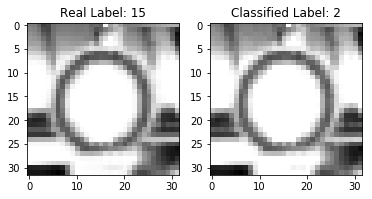

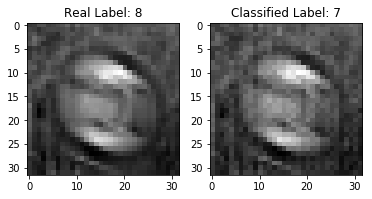

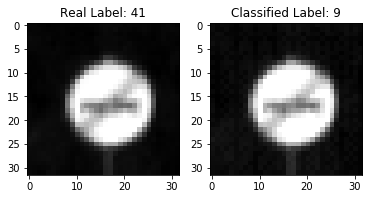

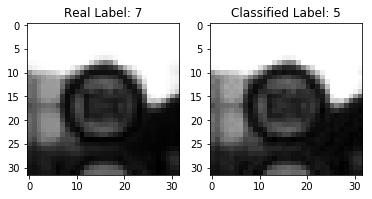

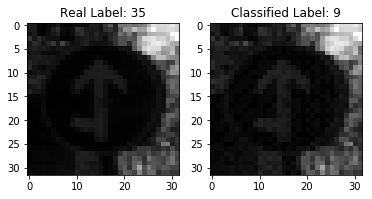

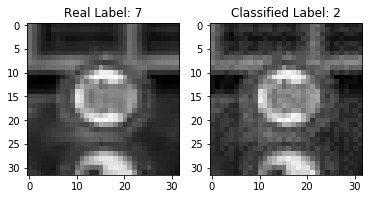

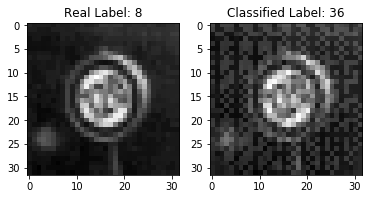

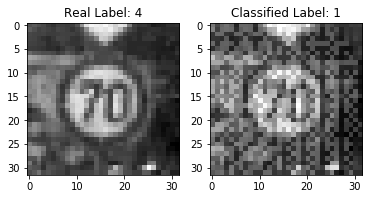

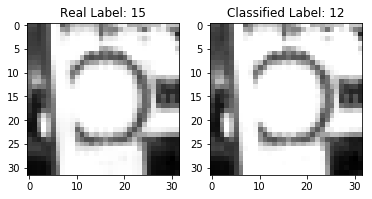

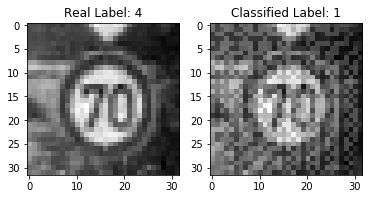

In [17]:

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import torch
import torchvision
import torchvision.datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

use_cuda=True
image_nc=1
epochs = 100

batch_size = 128
BOX_MIN = 0
BOX_MAX = 1

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

pretrained_model = "./target_model.pth"
targeted_model = target_net().to(device)
targeted_model.load_state_dict(torch.load(pretrained_model))
targeted_model.eval()

#test to make sure restoring model worked
num_correct2 = 0
for i, data in enumerate(test_dataloader, 0):
    test_img2, test_label2 = data
    test_img2, test_label2 = test_img2.to(device), test_label2.to(device)
    test_label2 = torch.argmax(test_label2,1)
    pred_lab2 = torch.argmax(targeted_model(test_img2), 1)
    num_correct2 += torch.sum(pred_lab2==test_label2,0)

print('accuracy in testing set: %f\n'%(100*num_correct2.item()/len(test_dataset)))


model_num_labels = 43

models_path = "./models/"
if not os.path.exists(models_path):
    os.makedirs(models_path)
            
# train dataset and dataloader declaration
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=1)
advGAN = AdvGAN_Attack(device,
                          targeted_model,
                          model_num_labels,
                          image_nc,
                          BOX_MIN,
                          BOX_MAX)

advGAN.train(dataloader, epochs)

advGAN.test(test_dataloader)

#ideas for optimizing:
#improve target classifier - stop it from overfitting
#color